# Handwritten Digit Prediction using Linear Model
_Build a machine learning model to classify a handwritten digit using a linear model._

In [1]:
# Imports required packages

import numpy as np

from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import ConfusionMatrixDisplay

import matplotlib.pyplot as plt

## Retrieving the Data

The _MNIST_ is a database of handwritten digits with 784 features. The raw data available at http://yann.lecun.com/exdb/mnist/. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. The images were centered in a 28x28 image by computing the center of mass of the pixels, and translated the image so as to position this point at the center of the 28x28 field.

In [2]:
# Fetches the data set and caches it

# NOTE: This step may take several seconds to complete as it downloads 
# the data from web and then caches it locally

mnist = fetch_openml("mnist_784", as_frame=False)

In [3]:
# Checks the available bunch objects
print(mnist.keys())

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])


So, mnist.data and mnist.target will provide the data set and targets, respectively. Other properties might not be applicable as far as this experiment is concerned.

## Exploratory Data Analysis (EDA)

In [4]:
# Finds the shape of the data
print(mnist.data.shape)

(70000, 784)


In [5]:
# Similarly, finds the shape of the target
print(mnist.target.shape)

(70000,)


In [6]:
# Let's view target of first few observations
print(mnist.target[:20])

['5' '0' '4' '1' '9' '2' '1' '3' '1' '4' '3' '5' '3' '6' '1' '7' '2' '8'
 '6' '9']


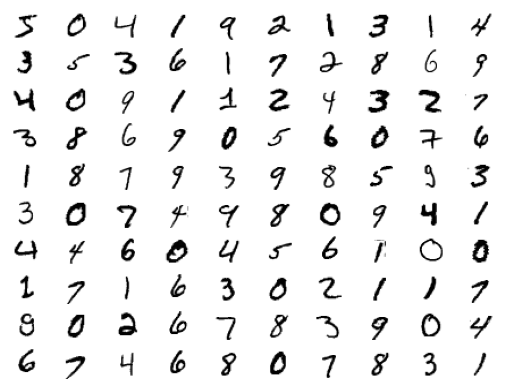

In [7]:
# Let's plot first 100 handwritten digits in a 10x10 subplots in a figure

for idx, image_data in enumerate(mnist.data[:100]):
    plt.subplot(10, 10, idx + 1)
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap = "binary")
    plt.axis("off")

plt.show()

## Modeling

In [8]:
# Converts target type from 'char' to 'integer'
mnist.target = mnist.target.astype(int)

In [9]:
# Split the data set into train and test data set.

# NOTE: Data set is already shuffled, and no further shuffling is being performed here.
# As recommended for this dataset, train and test set ratio maintained is 60000:10000.

X_train, X_test, y_train, y_test = \
    mnist.data[:60000], mnist.data[60000:], mnist.target[:60000], mnist.target[60000:]

### Using Binary Classifier for Multiclass Classification Task

In [10]:
# Initializes SVM classifier
svm_clf = SVC(random_state=42)

# Fits the model with train set
# NOTE: This step may take several minutes to complete
svm_clf.fit(X_train, y_train)

SVC(random_state=42)

In [11]:
# Takes one sample from test set, performs prediction and then compares with the actual label
print("Prediction:", svm_clf.predict(X_test[:1]))
print("Actual Label:", y_test[:1])

Prediction: [7]
Actual Label: [7]


In [12]:
# Retrieves decision scores against all classes. 

svm_clf_decision_scores = svm_clf.decision_function(X_test[:1])
print("Decision Scores:", svm_clf_decision_scores)

Decision Scores: [[ 3.80895496 -0.30212376  6.19343167  8.29375992  1.71167996  4.76436748
   0.69153837  9.31783975  2.75699419  7.28292338]]


In [13]:
# The class with the highest score gets predicted.
svm_clf.classes_[svm_clf_decision_scores.argmax()]

7

SVM classifier internally uses OvO strategy to train `45 (N * (N-1) / 2)` [`N` is the number of classes] binary classifiers and printed prediction scores from the duets.

OvO and OvR strategy can also be forced directly through the class `OneVsOneClassifier` and `OneVsRestClassifier`, respctively.

Let's try classification with the `OneVsRest` strategy.

In [14]:
# Initializes OvR classifier with SVC as estimator
ovr_clf = OneVsRestClassifier(SVC(random_state=42), n_jobs = -1)

# Fits the model
# NOTE: This step may take several tens of minutes to complete
ovr_clf.fit(X_train, y_train)

OneVsRestClassifier(estimator=SVC(random_state=42), n_jobs=-1)

In [15]:
# Takes one sample from test set, performs prediction and then compares with the actual label
print("Prediction:", ovr_clf.predict(X_test[:1]))
print("Actual Label:", y_test[:1])

Prediction: [7]
Actual Label: [7]


In [16]:
# Checks for the number of internal estimators created out of OvR strategy
print("Number of Estimators:", len(ovr_clf.estimators_))

Number of Estimators: 10


### Using Multiclass Classifier for Multiclass Classification Task

Models such as SGD classifier and random forest classifier have built-in feature to handle multiple classes. So, OvR or OvO strategy does not have to be specified for these models.

In [17]:
# Initialize the classifier
sgd_clf = SGDClassifier(n_jobs=-1, random_state=42)

# Calculates cross-validation score for multiclass prediction
sgd_clf_multiclass_accuracy_cv = cross_val_score(
    sgd_clf, X_train, y_train, scoring="accuracy", cv=5, n_jobs=-1, verbose=3)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[CV] END ................................ score: (test=0.881) total time= 1.7min
[CV] END ................................ score: (test=0.887) total time= 1.7min


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.7min remaining:  2.5min


[CV] END ................................ score: (test=0.881) total time= 1.7min
[CV] END ................................ score: (test=0.883) total time= 1.7min
[CV] END ................................ score: (test=0.866) total time= 1.7min


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.8min finished


In [18]:
# Shows the multiclass prediction performance of SGD classifier
print("Multiclass Prediction Performance of SGD Classifier: {:.1f}%".format(
    np.mean(sgd_clf_multiclass_accuracy_cv) * 100))

Multiclass Prediction Performance of SGD Classifier: 88.0%


## Error Analysis

Before performing error analysis, let's first scale the feature values as they presently range from 0 to 255.

In [19]:
# Instantiate scaler object
std_scaler = StandardScaler()

# Scales the feature values
X_train_scaled = std_scaler.fit_transform(X_train)

In [20]:
# Initializes the classifier (with default parameters)
sgd_clf = SGDClassifier(n_jobs=-1, random_state=42)

# Performs cross-validation predictions
# NOTE: This step may take several minutes to complete
cv_predictions = cross_val_predict(
    sgd_clf, X_train_scaled, y_train, cv=5, n_jobs=-1, verbose=3, method="predict")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  4.3min remaining:  6.4min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.5min finished


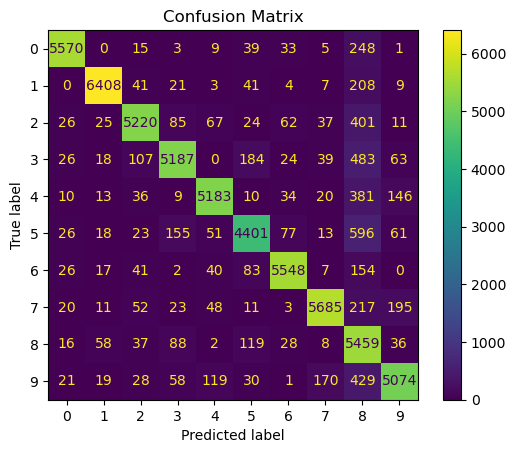

In [21]:
# Plots the confusion matrix

ConfusionMatrixDisplay.from_predictions(y_train, cv_predictions)

plt.title("Confusion Matrix")
plt.show()

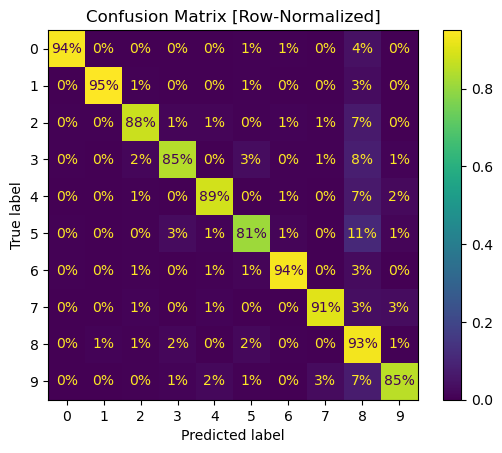

In [22]:
# Plots the normalized confusion matrix by dividing each value by the total number of images in the
# corresponding (true) class (i.e., divide by the row’s sum).
    
ConfusionMatrixDisplay.from_predictions(y_train, cv_predictions, normalize="true", values_format=".0%")

plt.title("Confusion Matrix [Row-Normalized]")
plt.show()

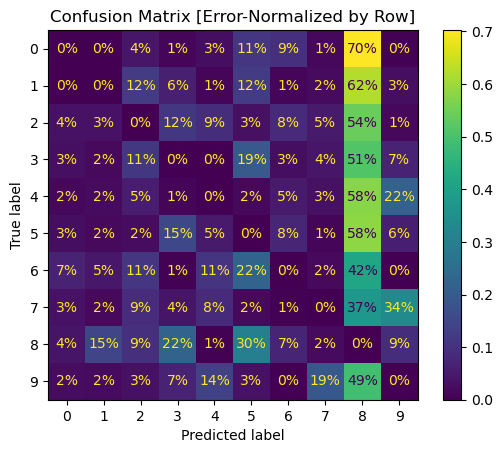

In [23]:
# Renders the confusion matrix to emphasis more on incorrect predictions than the correct predictions

sample_weight = (cv_predictions != y_train) 

ConfusionMatrixDisplay.from_predictions(
    y_train, cv_predictions, sample_weight=sample_weight, normalize="true", values_format=".0%")
plt.title("Confusion Matrix [Error-Normalized by Row]")
plt.show()


The column for class 8 is now really bright, which confirms that many images got misclassified as 8s. In fact this is the most common misclassification for  almost all classes.